In [3]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from shapely.geometry import Point
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_database.db')

In [ ]:
import geopandas as ggpd

In [ ]:
data = pd.read_csv("yellow_tripdata_2016-01.csv") 
data.head()

In [ ]:
cleandata = data[data.payment_type == 2]
cleanerdata = data[data.trip_distance != 0]
cleanerdata.head()
cleanerdata["tpep_pickup_datetime"] = pd.to_datetime(cleanerdata['tpep_pickup_datetime'])

In [ ]:
cleanerdata.index = cleanerdata['tpep_pickup_datetime']
tips = cleanerdata["tip_amount"]
tips.index = cleanerdata['tpep_pickup_datetime']
lol = tips.resample('D').mean()
print(lol[1])

In [ ]:
# Download the Trip Record Data
for month in range(1,2):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "yellow_tripdata_2018-{0:0=2d}.csv".format(month), 
                               "nyc.2018-{0:0=2d}.csv".format(month))

# Download the location Data
urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")

In [2]:
df = pd.read_csv("nyc.2018-01.csv", nrows=10)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0,0.3,16.55


In [7]:
j, chunksize = 1, 100000
for month in range(1,2):
    fp = "nyc.2018-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df.index += j
        df.to_sql('table_record', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

In [8]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [9]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [10]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [11]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [12]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


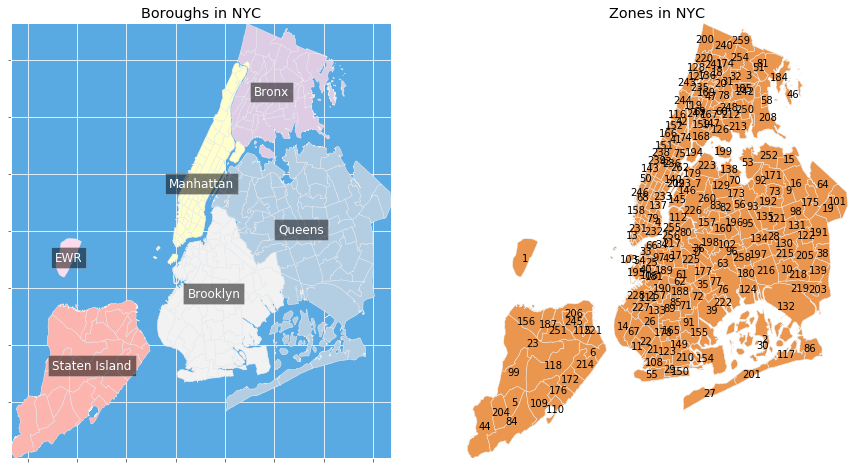

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
ax.set_yticklabels([])
ax.set_xticklabels([])
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
plt.axis('off')
draw_zone_map(ax, sf)

In [25]:
df_ta = pd.read_sql_query('SELECT PULocationID AS LocationID, sum(total_amount)/count(total_amount) AS TotalAmount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
loc = df_loc[["LocationID", "zone", "borough"]]
df_ta = df_ta.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_ta['LocationID'].tolist(), df_ta['TotalAmount'].tolist()))
PUtop3 = df_ta.sort_values(by=['TotalAmount'], ascending=False).set_index("LocationID").head(3)

In [26]:
PUtop3

,TotalAmount,zone,borough
LocationID,,,
5,110.880000,Arden Heights,Staten Island
253,91.528696,Willets Point,Queens
44,89.800000,Charleston/Tottenville,Staten Island


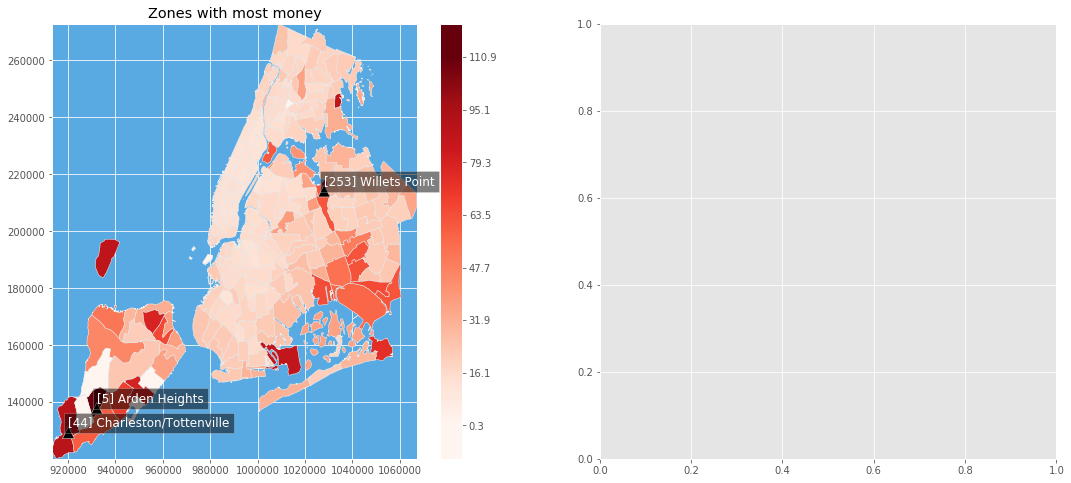

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most money")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())

In [32]:
df_1 = pd.read_sql_query('SELECT PULocationID AS LocationID, sum(total_amount)/count(total_amount) AS TotalAmount  \
                                 FROM table_record \
                                 WHERE passenger_count < 1 \
                                 GROUP BY PULocationID', nyc_database)
df_0 = pd.read_sql_query('SELECT PULocationID AS LocationID,sum(total_amount)/count(total_amount)  AS TotalAmount  \
                                 FROM table_record \
                                 WHERE passenger_count >= 1 \
                                 GROUP BY PULocationID', nyc_database)
df_3 = pd.read_sql_query('SELECT DOLocationID AS LocationID, sum(total_amount)/count(total_amount) AS TotalAmount  \
                                 FROM table_record \
                                 WHERE passenger_count < 1 \
                                 GROUP BY DOLocationID', nyc_database)
df_4 = pd.read_sql_query('SELECT DOLocationID AS LocationID,sum(total_amount)/count(total_amount)  AS TotalAmount  \
                                 FROM table_record \
                                 WHERE passenger_count >= 1 \
                                 GROUP BY DOLocationID', nyc_database)

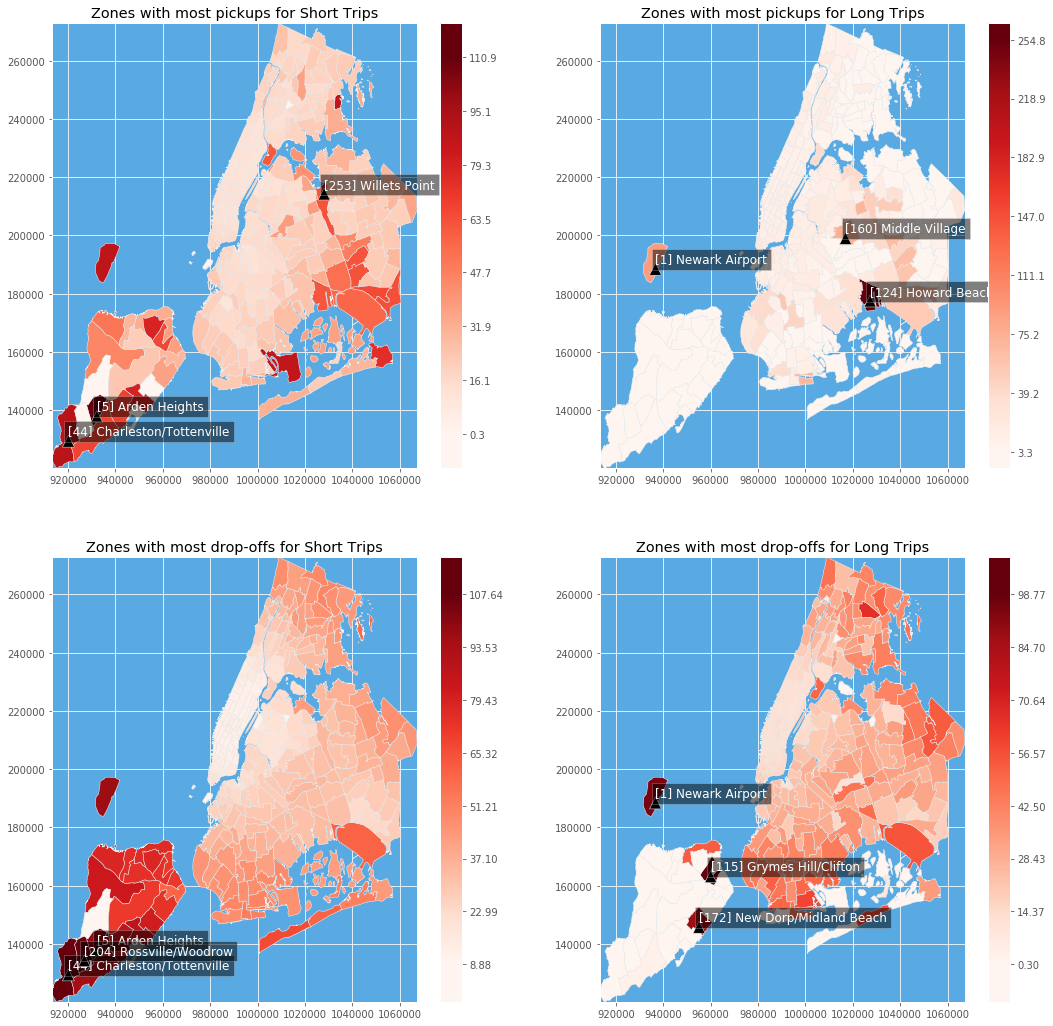

In [34]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
loc = df_loc[["LocationID", "zone", "borough"]]
df_0 = df_0.merge(loc, left_on="LocationID", right_on="LocationID")

PU = dict(zip(df_0['LocationID'].tolist(), df_0['TotalAmount'].tolist()))
PU3 = df_0.sort_values(by=['TotalAmount'], ascending=False).set_index("LocationID").head(3)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, sf, heat=PU, text=PU3.index.tolist())

df_1 = df_1.merge(loc, left_on="LocationID", right_on="LocationID")
PU = dict(zip(df_1['LocationID'].tolist(), df_1['TotalAmount'].tolist()))
PU3 = df_1.sort_values(by=['TotalAmount'], ascending=False).set_index("LocationID").head(3)

ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, sf, heat=PU, text=PU3.index.tolist())

df_4 = df_4.merge(loc, left_on="LocationID", right_on="LocationID")
PU = dict(zip(df_4['LocationID'].tolist(), df_4['TotalAmount'].tolist()))
PU3 = df_4.sort_values(by=['TotalAmount'], ascending=False).set_index("LocationID").head(3)

ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, sf, heat=PU, text=PU3.index.tolist())

df_3 = df_3.merge(loc, left_on="LocationID", right_on="LocationID")
PU = dict(zip(df_3['LocationID'].tolist(), df_3['TotalAmount'].tolist()))
PU3 = df_3.sort_values(by=['TotalAmount'], ascending=False).set_index("LocationID").head(3)

ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, sf, heat=PU, text=PU3.index.tolist())


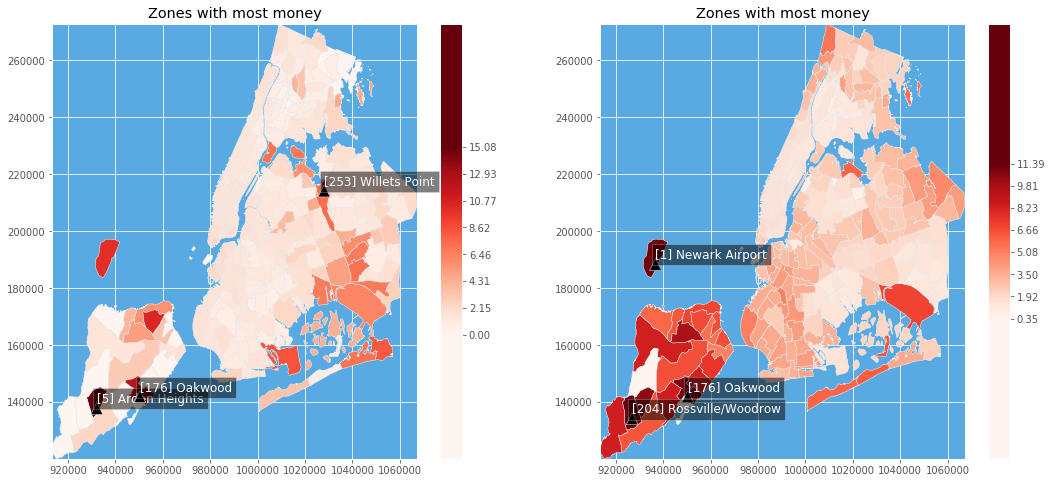

In [37]:
df_5 = pd.read_sql_query('SELECT PULocationID AS LocationID, sum(tip_amount)/count(tip_amount)  AS TipAmount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)
df_6 = pd.read_sql_query('SELECT DOLocationID AS LocationID, sum(tip_amount)/count(tip_amount) AS TipAmount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_database)
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
loc = df_loc[["LocationID", "zone", "borough"]]
df_5 = df_5.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_5['LocationID'].tolist(), df_5['TipAmount'].tolist()))
PUtop3 = df_5.sort_values(by=['TipAmount'], ascending=False).set_index("LocationID").head(3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most money")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())

df_6 = df_6.merge(loc, left_on="LocationID", right_on="LocationID")
PUcount = dict(zip(df_6['LocationID'].tolist(), df_6['TipAmount'].tolist()))
PUtop3 = df_6.sort_values(by=['TipAmount'], ascending=False).set_index("LocationID").head(3)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most money")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())